## ULMFiT-2 Blue-or-Red Training: 2019 Tweets

In [1]:
from fastai.text.all import *
from rich import inspect

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
from ideology_utils import *

In [15]:
path = Path()
path_19 = '/home/cdaniels/fastai-projects/blue-or-red/data_full'

In [16]:
df = pd.read_csv("blue_red_training_valid_2019.csv")

#### Preprocess each of the tweets

In [19]:
df = preprocess_tweets(df)

#### Shuffle and create Training (which Validation) and Testing Sets

In [27]:
df = df.sample(frac=1).reset_index(drop=True)

In [30]:
n_tr = Int(.9*(len(df)))
n_tr

619501

In [32]:
df_train, df_test = df[:n_tr], df[n_tr+1:]

### Fine-tuning a language model on Congrssional Tweets from 2019

In [35]:
dls_lm = TextDataLoaders.from_df(df_train, is_lm=True, valid_pct=0.1, bs=128)

In [36]:
dls_lm.show_batch(max_n=5)

,text,text_
0,"xxbos "" the xxmaj president has manufactured a crisis based on fear and is now holding our government hostage blatantly causing … xxbos xxmaj the # savetheinternet xxmaj act is another step @user are taking to make xxmaj washington work # forthepeople . xxmaj consumer … xxbos i was honored to be a part of the annual “ pass the xxmaj gavel ” meeting today where members of the house - senate",""" the xxmaj president has manufactured a crisis based on fear and is now holding our government hostage blatantly causing … xxbos xxmaj the # savetheinternet xxmaj act is another step @user are taking to make xxmaj washington work # forthepeople . xxmaj consumer … xxbos i was honored to be a part of the annual “ pass the xxmaj gavel ” meeting today where members of the house - senate #"
1,xxup xxunk this morning xxbos xxmaj the race for xxmaj naval superiority is more important now than ever as # xxmaj china and other xxup u.s . adversaries continue to bui … xxbos xxmaj today was our first conference committee meeting to finalize a full - year # xxup dhs funding bill . i was honored to presen … xxbos xxmaj citizenship is a constitutionally protected right granted to anyone born in,xxunk this morning xxbos xxmaj the race for xxmaj naval superiority is more important now than ever as # xxmaj china and other xxup u.s . adversaries continue to bui … xxbos xxmaj today was our first conference committee meeting to finalize a full - year # xxup dhs funding bill . i was honored to presen … xxbos xxmaj citizenship is a constitutionally protected right granted to anyone born in the
2,the opioid crisis : xxbos i am working with xxmaj democrats & & xxmaj republicans alike to shine a light on the countless xxmaj central xxmaj ohioans who do not know w … xxbos xxmaj thanks for coming and helping me vote xxmaj xxunk . xxmaj it was a lot of fun visiting with you and your mom ! xxbos xxmaj today we will be reviewing and analyzing various bills on important,opioid crisis : xxbos i am working with xxmaj democrats & & xxmaj republicans alike to shine a light on the countless xxmaj central xxmaj ohioans who do not know w … xxbos xxmaj thanks for coming and helping me vote xxmaj xxunk . xxmaj it was a lot of fun visiting with you and your mom ! xxbos xxmaj today we will be reviewing and analyzing various bills on important healthcare
3,film xxmaj breaking xxmaj point … xxbos xxup snap is the country 's most effective anti - hunger program helping 1 in 8 xxmaj americans afford a basic diet with most r … xxbos xxmaj to compete in the world economy we need an educated skilled cyber - ready xxunk bill with @user xxbos xxmaj sen . xxmaj inhofe reads from the xxmaj old xxmaj testament passages xxunk the coming of xxmaj,xxmaj breaking xxmaj point … xxbos xxup snap is the country 's most effective anti - hunger program helping 1 in 8 xxmaj americans afford a basic diet with most r … xxbos xxmaj to compete in the world economy we need an educated skilled cyber - ready xxunk bill with @user xxbos xxmaj sen . xxmaj inhofe reads from the xxmaj old xxmaj testament passages xxunk the coming of xxmaj jesus
4,# taxday xxbos xxmaj i ’m closely following the breaking news about the explosion in xxmaj sikeston . xxmaj everyone stay safe . xxbos # xxmaj columbine 19 yrs ago : 13 lives . # xxmaj newtown 5 yrs ago : 27 lives . # xxmaj parkland this year : 17 lives – yet xxmaj congress does noth … xxbos xxmaj happening xxmaj now : talking to @user on abc 's #,taxday xxbos xxmaj i ’m closely following the breaking news about the explosion in xxmaj sikeston . xxmaj everyone stay safe . xxbos # xxmaj columbine 19 yrs ago : 13 lives . # xxmaj newtown 5 yrs ago : 27 lives . # xxmaj parkland this year : 17 lives – yet xxmaj congress does noth … xxbos xxmaj happening xxmaj now : talking to @user on abc 's # thisweek


In [37]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], path=path, wd=0.1).to_fp16()

SuggestedLRs(valley=0.007585775572806597)

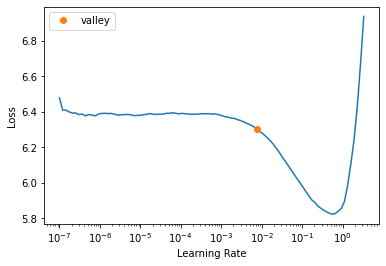

In [39]:
learn.lr_find()

In [42]:
learn.fit_one_cycle(1, .008)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.982595,3.674936,0.351246,39.446117,25:10


In [43]:
learn.unfreeze()
learn.fit_one_cycle(3, .008)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.580788,3.422384,0.377247,30.642372,25:38
1,3.384612,3.224929,0.397713,25.151791,25:45
2,3.200127,3.104323,0.412283,22.294119,25:50


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [44]:
learn.save_encoder('ulmfit-lm-2019')

### Training a text classifier

In [58]:
dls_clas = TextDataLoaders.from_df(df_train, valid_pct=.2, text_col='text', label='party',           text_vocab=dls_lm.vocab, bs=128)

In [59]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [60]:
learn = learn.load_encoder('ulmfit-lm-2019')

SuggestedLRs(valley=0.0010000000474974513)

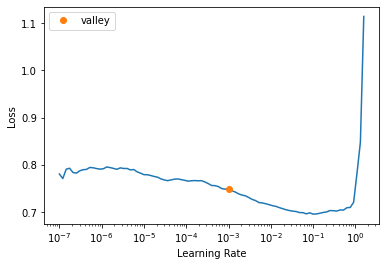

In [61]:
learn.lr_find()

In [62]:
learn.fit_one_cycle(2, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.570631,0.537363,0.717579,01:54
1,0.541811,0.520039,0.728580,01:55


In [63]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.505283,0.482395,0.752720,02:08
1,0.464765,0.440854,0.779524,02:09
2,0.450038,0.429671,0.787425,02:10


In [65]:
learn.freeze_to(-5)
learn.fit_one_cycle(4, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.393865,0.387677,0.810751,03:45
1,0.346702,0.369757,0.823341,03:46
2,0.291523,0.378272,0.827401,03:47


In [67]:
learn.save("clss-fifth-2019")

Path('models/clss-fifth-2019.pth')

In [68]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.281420,0.386347,0.827950,03:43
1,0.257919,0.393477,0.828563,03:47


In [69]:
learn.export("ulmfit-2019.pkl")

### Evaluate Against Test Set

In [135]:
dl_test = learn.dls.test_dl(df_test, with_labels=True)

In [138]:
predicts, actuals = learn.get_preds(dl = dl_test)
predicts, actuals = np.argmax(predicts, axis=1).numpy(), actuals.numpy()

In [141]:
sum(predicts == actuals)/len(predicts)

0.8273357255967341

The **82.7%** accuracy of the model predictions on the **Test Data** is nearly identical to that of the accuracy model prediction on the **Training Data.**

###  Load Model

In [56]:
learn = load_learner("ulmfit-2019.pkl")

In [162]:
ideology_score(Path(path_19)/"McConnellPress.csv","ulmfit-2019.pkl")

[0.95, 0.92, 1451]

In [174]:
path_22 = path/'tweets'/'tweets-congress-2022-05-24'
ideology_score(path_22/'McConnellPress.csv', "ulmfit-2019.pkl")

[0.94, 0.92, 18]